## Load flint

In [1]:
import matplotlib # Importing matplotlib for it working on remote server
import matplotlib.pyplot as plt
import matplotlib.colors as color

import os, sys
home_dir = os.getcwd()

import torch # All the torch modules

# because train
import random
random.seed(121)
torch.manual_seed(121)
torch.cuda.manual_seed(121)
torch.backends.cudnn.deterministic = True

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, transforms
import itertools, time

import numpy as np

In [2]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
train_shuffle = True
test_shuffle = True
train_epoch_info = []
test_epoch_info = []

criterion = nn.CrossEntropyLoss()
criterion2 = nn.L1Loss()

dataset = "cifar10"

In [3]:
n_classes = 10
N_EPOCH = 25
norm_mean = (0.4914, 0.4822, 0.4465)
norm_std = (0.247, 0.243, 0.261)    
train_loader = torch.utils.data.DataLoader( datasets.CIFAR10(home_dir + '/datasets', train=True, download=True, transform=transforms.Compose([ transforms.RandomCrop(32, padding=2), transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std) ])), batch_size=64, shuffle=train_shuffle, num_workers=32)
test_loader = torch.utils.data.DataLoader( datasets.CIFAR10(home_dir + '/datasets', train=False, download=True, transform=transforms.Compose([ transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std) ])), batch_size=32, shuffle=test_shuffle, num_workers=20) #batch_size 32
train_data = datasets.CIFAR10(home_dir + '/datasets', train=True, download=True, transform=transforms.Compose([ transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std) ]))
test_data = datasets.CIFAR10(home_dir + '/datasets', train=False, download=True, transform=transforms.Compose([ transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std) ]))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [4]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
class BasicBlock3(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock3, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.activ = nn.ReLU()
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = self.activ(self.conv1(x[0]))
        out = self.conv2(out)
        out += self.shortcut(x[0])
        out = self.activ(out)
        return [out, x[0]]

class ResNet_34(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, in_maps=1):
        super(ResNet_34, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(in_maps, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.fc = nn.Linear(512*block.expansion, num_classes)
        self.activ = nn.ReLU()

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        #out = F.relu(self.bn1(self.conv1(x))) # For ResNet with BatchNorm layer
        out = self.activ(self.conv1(x))
        out = self.layer1([out, out])
        out = self.layer2(out)
        out_inter1 = self.layer3(out)
        out = self.layer4(out_inter1)
        out_inter1, out_inter2 = out_inter1[0], out[1]
        out = out[0]
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return self.activ(out), [out_inter1, out_inter2]

class MyResNet(nn.Module):
    def __init__(self, version='4', bn=False, n_classes=10, in_maps=1):
        super(MyResNet, self).__init__()
        self.convnet = ResNet_34(BasicBlock3, [2, 2, 2, 2], num_classes=n_classes, in_maps=in_maps)

        num_ftrs = self.convnet.fc.in_features
        self.fc2 = nn.Linear(num_ftrs, n_classes)
        self.convnet.fc = nn.Linear(num_ftrs, num_ftrs) # 200 is the number of output classes in CUB_2011/200 dataset

    def forward(self, inp):
        output, output_intermediate = self.convnet(inp)     
        return self.fc2(output), output_intermediate

In [6]:
class attr_RN18_multi(nn.Module):
    def __init__(self, out_size=49*2, in_maps1=256, in_maps2=512):
        super(attr_RN18_multi, self).__init__()
        self.conv1 = nn.Conv2d(in_maps1, 64, kernel_size=3, padding=1, stride=2)
        self.conv2 = nn.Conv2d(in_maps2, 64, kernel_size=3, padding=1, stride=1)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*3*3, out_size, bias=True)
        #self.activ = nn.LeakyReLU()
        self.activ = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool2d(3)

    def forward(self, inter_list):
        x1 = self.activ( self.conv1(inter_list[0]) )
        x2 = self.activ( self.conv2(inter_list[1]) )
        x = torch.cat((x1, x2), 1)
        x = self.activ( self.conv3(x) )
        x = self.pool(x).view(-1, 64*3*3)
        #x = self.fc1(x) # Till model 9
        #x = x.view(-1, 64*3*)
        x = self.activ(self.fc1(x))
        #x = self.fc1(x)
        return x

class decode_CIFAR(nn.Module):
    def __init__(self, in_size=64*2):
        super(decode_CIFAR, self).__init__()
        self.fc1 = nn.Linear(in_size, 64*10, bias=True)
        self.trconv1 = nn.ConvTranspose2d(10, 24, kernel_size=3, stride=2, padding=1, output_padding=1, bias=True)
        self.trconv2 = nn.ConvTranspose2d(24, 8, kernel_size=3, stride=2, padding=1, output_padding=1, bias=True)
        self.fc2 = nn.Linear(8*32*32, 3*32*32)
        self.activ = nn.ReLU()

    def forward(self, inp):
        x = self.fc1(inp)
        x = x.view(-1, 10, 8, 8)
        x = self.activ( self.trconv1(x) )
        x = self.activ( self.trconv2(x) )
        x = x.view(-1, 8*32*32)
        x = self.fc2(x).view(-1, 3, 32, 32)
        return x
    
class explainer(nn.Module):
    def __init__(self, in_size=30, max_elem=15, n_classes=200):
        super(explainer, self).__init__()
        self.max_elem = max_elem
        self.fc1 = nn.Linear(in_size, n_classes, bias=True)
        self.drop = nn.Dropout(0.01)

    def forward(self, inp):
        # Select the max elems by multiplying input by the appropriate tensor
        x = self.drop(inp)
        return self.fc1(x)

In [7]:
latent_size = 36
f = MyResNet(version='34', bn=False, n_classes=10, in_maps=3).to(device)
g = attr_RN18_multi(out_size=latent_size).to(device)
d = decode_CIFAR(in_size=latent_size).to(device)
h = explainer(in_size=latent_size, n_classes=10).to(device)
optimizer = optim.Adam(itertools.chain(f.parameters(), g.parameters(), d.parameters(), h.parameters()), lr=0.0001)

In [8]:
checkpoint1 = torch.load('output/' + dataset + '/cifar10_flint.pt', map_location='cpu') # For MNIST
f.load_state_dict(checkpoint1['f_state_dict'])
g.load_state_dict(checkpoint1['g_state_dict'])
h.load_state_dict(checkpoint1['h_state_dict'])
d.load_state_dict(checkpoint1['d_state_dict'])
f, g, h, d = f.eval(), g.eval(), h.eval(), d.eval()

In [9]:
def analyze(f, g, h, d, device, test_loader, location):
    f.eval(), g.eval(), h.eval(), d.eval()
    f, g, h, d = f.to(device), g.to(device), h.to(device), d.to(device)
    conf_matx_fy = np.zeros([10, 10]) # n_classes x n_classes
    conf_matx_hf = np.zeros([10, 10])
    conf_matx_hy = np.zeros([10, 10])
    for batch_info in test_loader:
        data, target = batch_info[0].to(device), batch_info[1].to(device)
        output, inter = f(data)
        embed = g(inter)
        rec_data, expl = d(embed), h(embed)
        pred_f = output.argmax(dim=1).cpu().data.numpy()
        pred_h = expl.argmax(dim=1).cpu().data.numpy()
        y = target.cpu().data.numpy()
        for j in range(y.shape[0]):
            conf_matx_fy[pred_f[j], y[j]] += 1
            conf_matx_hf[pred_h[j], pred_f[j]] += 1
            conf_matx_hy[pred_h[j], y[j]] += 1

    return conf_matx_fy, conf_matx_hf, conf_matx_hy

facc, fidelity, gacc = analyze(f, g, h, d, device, test_loader, '')
print ("Accuracy of f (in %):", np.diag(facc).sum()*100/len(test_data))
print ("Accuracy of g (in %):", np.diag(gacc).sum()*100/len(test_data))
print ("Fidelity of g (in %):", np.diag(fidelity).sum()*100/len(test_data))

Accuracy of f (in %): 84.02
Accuracy of g (in %): 84.33
Fidelity of g (in %): 92.9


## interpret of flint

In [10]:
def collect_g_data(f, g, h, device, data, subset=False):
    f.eval(), g.eval(), h.eval()
    f, g, h = f.to(device), g.to(device), h.to(device)
    weights = h.fc1.weight.cpu().data.numpy()
    g_data = []
    all_y = []
    num_batch = 0
    subset_data = []
    expl_data = [] # Only append data in this if subset is true, else it'll possibly increase the time by a lot
    expl_pred = []
    if not subset:
        dataloader = torch.utils.data.DataLoader(data, batch_size=16*4, shuffle=False, num_workers=64)
    else:
        dataloader = torch.utils.data.DataLoader(data, batch_size=20, shuffle=True, num_workers=20)
    for batch_info in dataloader:
        num_batch += 1
        data, target = batch_info[0].to(device), batch_info[1].to(device)                                 
        output, inter = f(data)
        embed = g(inter)
        expl = np.zeros(embed.shape)
        pred = h(embed).argmax(dim=1).cpu().data.numpy()
        g_data.append(embed.cpu().data.numpy())
        all_y += list(target.cpu().data.numpy())
        expl_pred += list(h(embed).argmax(dim=1).cpu().data.numpy())
        if subset:
            subset_data.append(data)
            for i in range(pred.shape[0]):
                expl[i] = embed[i].cpu().data.numpy() * weights[pred[i]]
                expl[i] = expl[i]/expl[i].max()
            expl_data.append(expl)
            if num_batch > 50:
                subset_data = torch.cat(subset_data).unsqueeze(dim=1) #unsqueeze is done to make code in save image functions compatible with shape of subset_data
                break
    g_data = np.concatenate(g_data)
    if subset:
        expl_data = np.concatenate(expl_data)
    return g_data, np.array(all_y), subset_data, expl_data, np.array(expl_pred)

In [11]:
def sparse_sense(f, g, h, data, mults):
    f, g, h = f.eval(), g.eval(), h.eval()
    gdata = collect_g_data(f, g, h, device, data)[0]
    pred = h(torch.tensor(gdata).to(device)).argmax(dim=1).cpu().data.numpy()
    weights  = h.fc1.weight.cpu().data.numpy()
    result = []
    for multiplier in mults:
        sparse = 0
        for i in range(pred.shape[0]):
            expl_vec = np.abs(gdata[i] * weights[pred[i]])
            thresh = np.abs(expl_vec).max() / multiplier
            sparse += np.sum(expl_vec > thresh)
        #print (sparse/pred.shape[0])
        result.append(sparse/pred.shape[0])
    return result

mults = [1.5, 2.0, 2.5, 3.0, 4.0, 5.0]
conciseness = sparse_sense(f, g, h, test_data, mults)
print (conciseness)


[1.3805, 1.746, 2.1102, 2.5044, 3.1895, 3.7965]


In [12]:
def grad_inp_embed(f_gb, g, device, inp, embed_idx, dataset='mnist'):
    # Computes appropriate saliency map for an attribute w.r.t input
    # Assume inp of shape 1 x 28 x 28
    g = g.eval()
    inp = inp.unsqueeze(0)
    g, inp = g.to(device), inp.to(device)
    inp.requires_grad = True
    if dataset == 'qdraw':
        output, inter = f_gb.model(inp)
    else:
        output, inter = f_gb(inp)
    if dataset == 'qdraw':
        f_gb.model.zero_grad()
    else:
        f_gb.zero_grad()
    embed = g(inter)
    if dataset == 'mnist' or dataset == 'fmnist' or dataset == 'qdraw':
        grad = torch.autograd.grad(embed[0, embed_idx], inp)[0][0, 0].cpu().data.numpy()
    elif dataset == 'cifar10':
        grad = torch.autograd.grad(embed[0, embed_idx], inp)[0][0].abs().sum(dim=0).cpu().data.numpy() # Add the code to shift axes, then remove this comment
    #print (grad.shape)
    return grad

def optimize_inp(f, g, embed_idx, device, inp_shape=[1, 1, 28, 28], init=None, max_val=1.0, min_val=0.0, lmbd_tv=1.0, lmbd_bound=1.0, C=1.0, lmbd_l1=0):
    # Function to run activation maximization with partial initialization
    # initialize input with input shape and make requires_grad True
    f, g = f.eval().to(device), g.eval().to(device) 
    inp = torch.empty(inp_shape).to(device)
    if init is None:
        #4.0 * (nn.init.uniform_(inp) - 0.5) # Initialization line
        nn.init.uniform_(inp)
    else:
        inp = 1.0 * init
    inp.requires_grad = True
    new_lr = 0.05
    inp.to(device)
    for epoch in range(6):
        #optimizer = optim.SGD([inp], lr=new_lr, momentum=0.9)
        optimizer = optim.Adam([inp], lr=new_lr)
        new_lr = new_lr/2
        for i in range(50):
            optimizer.zero_grad()
            output, inter = f(inp)
            embed = g(inter)

            loss_l1 = (inp.abs()).mean()
            loss_bound = (( (inp > max_val).float() + (inp < min_val).float() )*(inp.abs())).mean()
            loss_tv = (inp[:, :, 0:inp_shape[2]-1, :] - inp[:, :, 1:inp_shape[2], :]).abs().mean() + (inp[:, :, :, 0:inp_shape[3]-1] - inp[:, :, :, 1:inp_shape[3]]).abs().mean()
            loss = C*embed[:, embed_idx].sum() - lmbd_l1 * loss_l1 - lmbd_bound * loss_bound - lmbd_tv * loss_tv

            loss.backward()
            inp.grad = -1 * inp.grad
            optimizer.step()
            if (i % 51 == 0 and i == 3):
                print (epoch, loss.item(), embed[:, embed_idx].sum(), loss_l1.item(), loss_bound.item(), loss_tv.item())
    return inp.cpu().data.numpy()

def save_expl_images_class_cifar(indices, data, gdata, f, f_copy, g, device, dataset, model_name='', d=None):
    # This function assumed specific shape of indices
    if dataset == 'qdraw' or dataset == 'cifar10':
        f_gb = gb.GuidedBackprop(f)
    else:
        f_gb = f
    f_copy = f_copy.eval()
    for i in range(indices.shape[2]): # Fixing the attribute (coordinate of attribute vector)
        for j in range(indices.shape[0]): # Fixing the class
            for k in range(indices.shape[1]):
                if indices[j, k, i] == -1:
                    continue
                img = unnorm(data[indices[j, k, i]][0].cpu().data.numpy(), norm_mean, norm_std)
                init_img = 0.4*data[indices[j, k, i]] 
                cur_img = optimize_inp(f_copy, g, i, device, list(init_img.shape), max_val=2.5, min_val=-2.5, init=init_img, lmbd_bound=20.0, lmbd_tv=20.0, C=2.0, lmbd_l1=0.0)
                grad = grad_inp_embed(f_gb, g, device, data[indices[j, k, i]][0], i, dataset=dataset)
                #if gdata[indices[j, k, i], i] < gdata[:, i].max()/4.0:
                    #continue
                fig = plt.figure()
                fig.add_subplot(1, 2, 1)
                plt.imshow(img)
                plt.axis('off')
                #fig.add_subplot(1, 5, 2)
                #plt.imshow(grad)
                #plt.axis('off')
                #fig.add_subplot(1, 5, 3)
                #attr = g(f(data[indices[j, k, i]][0].unsqueeze(0))[1])
                ######attr[:, i] = 0
                #plt.imshow(unnorm(d(attr)[0].cpu().data.numpy(), norm_mean, norm_std))
                #plt.axis('off')
                #attr[:, i] = 0
                #fig.add_subplot(1, 5, 4)
                #plt.imshow(unnorm(d(attr)[0].cpu().data.numpy(), norm_mean, norm_std))
                #plt.axis('off')
                fig.add_subplot(1, 2, 2)
                plt.imshow(unnorm(cur_img[0], norm_mean, norm_std).mean(axis=2) )
                plt.axis('off')
                #fig.add_subplot(1, 6, 6)
                #plt.imshow(unnorm(cur_img[0], np.array([0.0, 0.0, 0.0]), np.array([1.0, 1.0, 1.0])) )
                #plt.axis('off')
                fig.subplots_adjust(wspace=0.04) 
                plt.savefig('output/' + dataset + '_output/explanation_images_' + model_name  + '/attr' + str(i) + '_class' + str(j) + '_' + str(k), bbox_inches='tight', pad_inches = 0.03)
                plt.close()
                
    return


In [13]:
def extract_attr_class_max(gdata, all_y, expl_data, expl_pred, n_idx=1, thresh=0.1):
    n_class = all_y.max() + 1
    indices = np.zeros([n_class, n_idx, gdata.shape[1]])
    true_max = np.max(gdata, axis=0)
    for i in range(n_class):
        pos_arr = np.where(all_y == i)[0]
        gdata_class = gdata[pos_arr] # Data for the ith class
        local_idx = np.argsort(-gdata_class, axis=0)[:n_idx] 
        indices[i] = pos_arr[local_idx]
    if len(expl_data > 0):
        indices2 = np.zeros([n_class, n_idx, gdata.shape[1]]) - 1
        expl_class = np.zeros([n_class, gdata.shape[1]])
        for i in range(n_class):
            pos_arr = np.where(expl_pred == i)[0]
            expl_class[i] = expl_data[pos_arr].mean(axis=0)
            select_attr = np.where(expl_class[i] > thresh)[0]
            for attr in select_attr:
                indices2[i, :, attr] = indices[i, :, attr]
        return indices2.astype(int), expl_class 
    return indices.astype(int)

In [14]:
def generate_model_explanations(f, g, h, d, data, device, dataset, model_name='', subset=False):
    if not subset:
        print ('Collecting attribute vectors on the given data')
    else:
        print ('Collecting attribute vectors on random subset of the given data')
    gdata, all_y, subset_data, expl_data, expl_pred = collect_g_data(f, g, h, device, data, subset=subset)
    indices2, rel = extract_attr_class_max(gdata, all_y, expl_data, expl_pred, 3, thresh=0.1)
    try:
        os.mkdir('output/' + dataset + '_output/explanation_images_' + str(model_name))	
        #os.mkdir('output/' + dataset + '_output/explanation_images_' + str(model_name) + '/inp_optimize')
    except:
        print ('Writing images in an old folder. May overwrite some files')
    print ('Saving images')
    if not subset:
        subset_data = data
    f_copy = MyResNet(version='34', bn=False, n_classes=10, in_maps=3).to(device)
    f_copy.load_state_dict(checkpoint1['f_state_dict'])
    
    #save_expl_images_class(indices2, subset_data, gdata, f, f_copy, g, device, dataset, str(model_name), d)
    return rel

print ('Generating explanations')
global_rel = generate_model_explanations(f, g, h, d, train_data, device, dataset, model_name='sample_model', subset=True)

Generating explanations
Writing images in an old folder. May overwrite some files
Saving images


(10, 36)


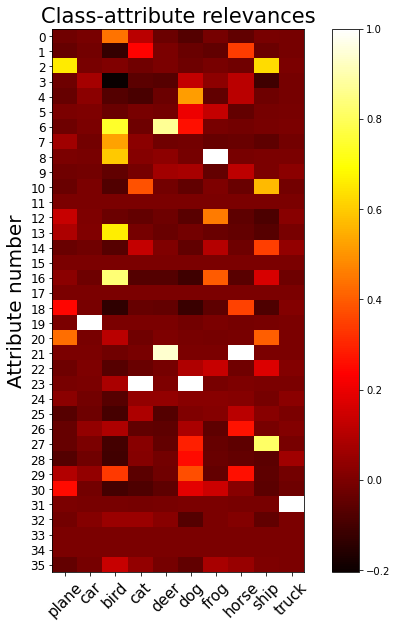

In [15]:
print(global_rel.shape)
def plot_rel(rel, dataset):
    rel2 = 1.0*rel
    class_name = classes
    x_pos = np.array(range(rel.shape[1])).astype(str)
    x_pos = np.array(['$\phi_{'+i+'}$' for i in x_pos])
    x_pos_int = np.array([i for i in np.array(range(rel.shape[1]))])

    plt.figure(figsize=(10, 10))
    plt.imshow(rel.T, cmap='hot', aspect=0.6)
    plt.xticks(list(range(rel.shape[0])), class_name, fontsize=15, rotation=45)   
    plt.yticks(list(range(rel.shape[1])), range(rel.shape[1]), fontsize=12, rotation=0)
    plt.ylabel('Attribute number', fontsize=20)
    plt.title('Class-attribute relevances', fontsize=21)
    plt.colorbar()
    plt.show()
    
    return
plot_rel(global_rel, 'mnist')

Predicted class: truck


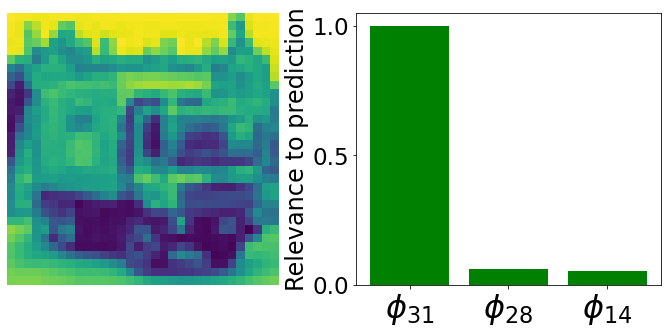

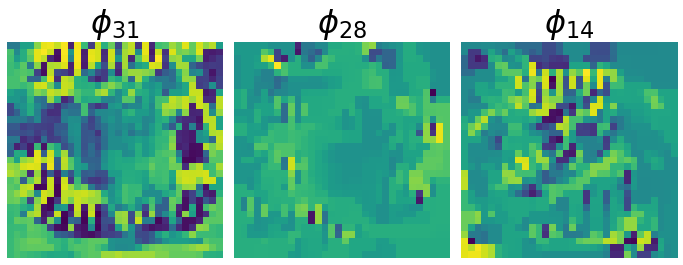

In [16]:
def analyze_img(f, g, h, d, idx, n_attr=3, save=False, location=None):
    f_copy, g, d = f.eval(), g.eval(), d.eval()
    f_copy, g, d = f_copy.to(device), g.to(device), d.to(device)
    init_img = test_data[idx][0].unsqueeze(0)

    init_shape = init_img.shape
    img = init_img[0, 0].cpu().data.numpy()

    # Complete the computations
    init_img=init_img.to(device)
    output, inter = f_copy(init_img)
    embed1 = g(inter)
    weights = h.fc1.weight.cpu().data.numpy()
    pred = h(embed1).argmax(dim=1).cpu().data.numpy()
    print ("Predicted class:", classes[pred[0]])
    expl1 = embed1[0].cpu().data.numpy() * weights[pred[0]]
    expl1 = expl1 / np.abs(expl1).max()
    attr_idx1 = expl1.argsort()[-1]
    attr_idx2 = expl1.argsort()[-2]
    attr_idx3 = expl1.argsort()[-3]
    cur_img1 = optimize_inp(f_copy, g, attr_idx1, device, list(init_img.shape), init=0.2*init_img, lmbd_bound=10.0, lmbd_tv=6.0, C=2.0, lmbd_l1=0.0)
    cur_img2 = optimize_inp(f_copy, g, attr_idx2, device, list(init_img.shape), init=0.2*init_img, lmbd_bound=10.0, lmbd_tv=6.0, C=2.0, lmbd_l1=0.0)
    cur_img3 = optimize_inp(f_copy, g, attr_idx3, device, list(init_img.shape), init=0.2*init_img, lmbd_bound=10.0, lmbd_tv=6.0, C=2.0, lmbd_l1=0.0)

    # Make the plot
    fig = plt.figure(figsize=(12, 5))
    fig.add_subplot(1, 2, 1)
    plt.imshow(img)
    #plt.title('Input sample', fontsize=28)
    plt.axis('off')

    fig.add_subplot(1, 2, 2)
    x_pos = np.array(range(expl1.shape[0])).astype(str)
    x_pos = np.array(['$\phi_{'+i+'}$' for i in x_pos])
    plt.bar(list(range(n_attr)), -1*np.sort(-1*expl1)[:n_attr], color='green')
    plt.xticks(list(range(n_attr)), x_pos[np.array([attr_idx1, attr_idx2, attr_idx3])], fontsize=32)
    plt.yticks([0, 0.5, 1], [0.0, 0.5, 1.0], fontsize=23)
    plt.ylabel('Relevance to prediction', fontsize=24)
    #plt.subplots_adjust(wspace=0.05)
    if not save:
        plt.show()
    else:
        plt.savefig(location + '/s' + str(idx) + '_rel_')
        plt.close()

    fig = plt.figure(figsize=(12, 5))
    fig.add_subplot(1, 3, 1)
    plt.imshow(cur_img1[0, 0])
    plt.axis('off')
    plt.title('$\phi_{'+str(attr_idx1)+'}$', fontsize=32)
    fig.add_subplot(1, 3, 2)
    plt.imshow(cur_img2[0, 0])
    plt.axis('off')
    plt.title('$\phi_{'+str(attr_idx2)+'}$', fontsize=32)
    fig.add_subplot(1, 3, 3)
    plt.imshow(cur_img3[0, 0])
    plt.axis('off')
    plt.title('$\phi_{'+str(attr_idx3)+'}$', fontsize=32)
    plt.subplots_adjust(wspace=0.05)
    if not save:
        plt.show()
    else:
        plt.savefig(location + '/s' + str(idx) + '_att3_')
        plt.close()
 
    return cur_img1, cur_img2

im1, im2 = analyze_img(f, g, h, d, 11, n_attr=3, save=False, location=None)


### Try to copy f to use gradient

In [17]:
class BasicBlock3(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock3, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.activ = nn.ReLU()
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = self.activ(self.conv1(x[0]))
        out = self.conv2(out)
        out += self.shortcut(x[0])
        out = self.activ(out)
        return [out, x[0]]

class ResNet_34(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, in_maps=1):
        super(ResNet_34, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(in_maps, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.fc = nn.Linear(512*block.expansion, num_classes)
        self.activ = nn.ReLU()

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        #out = F.relu(self.bn1(self.conv1(x))) # For ResNet with BatchNorm layer
        out = self.activ(self.conv1(x))
        out = self.layer1([out, out])
        out = self.layer2(out)
        out_inter1 = self.layer3(out)
        out = self.layer4(out_inter1)
        out_inter1, out_inter2 = out_inter1[0], out[1]
        out = out[0]
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return self.activ(out)

class MyResNet(nn.Module):
    def __init__(self, version='4', bn=False, n_classes=10, in_maps=1):
        super(MyResNet, self).__init__()
        self.convnet = ResNet_34(BasicBlock3, [2, 2, 2, 2], num_classes=n_classes, in_maps=in_maps)

        num_ftrs = self.convnet.fc.in_features
        self.fc2 = nn.Linear(num_ftrs, n_classes)
        self.convnet.fc = nn.Linear(num_ftrs, num_ftrs) # 200 is the number of output classes in CUB_2011/200 dataset

    def forward(self, inp):
        output = self.convnet(inp)     
        return self.fc2(output)

In [18]:
f_copy = f = MyResNet(version='34', bn=False, n_classes=10, in_maps=3).to(device)
f_copy.load_state_dict(checkpoint1['f_state_dict'])

<All keys matched successfully>

In [19]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
out = f_copy(images.to(device))

In [20]:
f

MyResNet(
  (convnet): ResNet_34(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock3(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (activ): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (shortcut): Sequential()
      )
      (1): BasicBlock3(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (activ): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (shortcut): Sequential()
      )
    )
    (layer2): Sequential(
      (0): BasicBlock3(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (activ): ReLU()
        (conv2): Conv2d(1

In [21]:
f_copy

MyResNet(
  (convnet): ResNet_34(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock3(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (activ): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (shortcut): Sequential()
      )
      (1): BasicBlock3(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (activ): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (shortcut): Sequential()
      )
    )
    (layer2): Sequential(
      (0): BasicBlock3(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (activ): ReLU()
        (conv2): Conv2d(1

In [22]:
f == f_copy

True

## captum on flint

In [23]:
import torch
import torch.nn.functional as F

torch.cuda.empty_cache()
# import gc
# del variables
# gc.collect()

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import datasets, transforms, models

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import NeuronConductance
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import DeepLiftShap
from captum.attr import visualization as viz

In [24]:
# model = models.resnet18(pretrained=True)
# model = model.eval()

In [25]:
# !wget -P $HOME/.torch/models https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

In [26]:
# labels_path = os.getenv("HOME") + '/.torch/models/imagenet_class_index.json'
# with open(labels_path) as json_data:
#     idx_to_labels = json.load(json_data)

In [27]:
# list(idx_to_labels.values())

In [28]:
# root = "./img/resnet"
dataset = datasets.CIFAR10(root, train = True, transform = None, target_transform = None, download = True)

NameError: name 'root' is not defined

In [ ]:
# transform = transforms.Compose([
#  transforms.Resize(256),
#  transforms.CenterCrop(224),
#  transforms.ToTensor()
# ])

# transform_normalize = transforms.Normalize(
#      mean=[0.485, 0.456, 0.406],
#      std=[0.229, 0.224, 0.225]
#  )

# img = Image.open('img/resnet/swan-3299528_1280.jpg')

# transformed_img = transform(img)

# input = transform_normalize(transformed_img)
# input = input.unsqueeze(0)

In [ ]:
# for _, data in enumerate(dataset):
#     plt.imshow(data[0])
#     plt.show()
#     print(data[1])

In [ ]:
# liste=[]
# for _, data in enumerate(dataset):
#     liste.append(data[1])

In [ ]:
# np.unique(np.array(liste))

In [ ]:
# class Net(nn.Module):
#     def __init__(self, f):
#         super(Net, self).__init__()
#         self.f = f
        
#     def forward(self, imgs):
#         out, _ = f(imgs)
#         return out
    
# net = Net(f)

In [ ]:
# import gc
# del model
# gc.collect()

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=True)

In [ ]:
unorm_mean = (-0.4914/0.247, -0.4822/0.243, -0.4465/0.261)
unorm_std = (1/0.247, 1/0.243, 1/0.261)
transform_unormalize=transforms.Compose([transforms.Normalize(unorm_mean, unorm_std)])

In [ ]:
def imshow(img, transpose = True):
    img = transform_unormalize(img)     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, labels = dataiter.next()

# for batch_idx, batch_info in enumerate(test_loader):
#     images, labels = batch_info[0].to(device), batch_info[1].to(device)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(len(images))))


# outputs, _ = f(images.to(device))
outputs = f_copy(images.to(device))

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(len(images))))

In [ ]:
images.shape

In [ ]:
ind = 3

input = images[ind].unsqueeze(0)
input.requires_grad = True

f.eval()

print("Mode evaluation")

In [ ]:
print(input.shape)
print(labels[ind].item())

In [ ]:
def attribute_image_features(algorithm, input, **kwargs):
    f_copy.zero_grad()
    tensor_attributions = algorithm.attribute(input, target=labels[ind], **kwargs) 
    return tensor_attributions
        

In [ ]:
input=input.to(device)

In [ ]:
saliency = Saliency(f_copy)
grads = saliency.attribute(input, target=labels[ind].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

In [ ]:
ig = IntegratedGradients(f_copy)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

In [ ]:
ig = IntegratedGradients(f_copy)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(nt, input, baselines=input * 0, nt_type='smoothgrad_sq',
                                      nt_samples=20, stdevs=0.2) #nt 100
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

In [ ]:
# dl = DeepLift(f_copy)
# attr_dl = attribute_image_features(dl, input, baselines=input * 0)
# attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

In [ ]:
# dl = DeepLift(f_copy)
# attributions, delta = dl.attribute(input, target=0, return_convergence_delta=True)
# print('DeepLift Attributions:', attributions)
# print('Convergence Delta:', delta)

In [ ]:
# dls = DeepLiftShap(f_copy)
# baseline_dist = torch.randn(images.shape) * 0.001
# baseline_dist = baseline_dist.to(device)
# attr_dls, delta = dls.attribute(input, baseline_dist, target=0, return_convergence_delta=True)
# print('DeepLiftSHAP Attributions:', attr_dls)
# print('Convergence Delta:', delta)

In [ ]:
input.shape

In [ ]:
input=input.to(device)
f_copy = f_copy.to(device)

In [ ]:
gs = GradientShap(f_copy)

# We define a distribution of baselines and draw `n_samples` from that
# distribution in order to estimate the expectations of gradients across all baselines
baseline_dist = torch.randn(input.shape) * 0.001
baseline_dist = baseline_dist.to(device)
attr_gs, delta = gs.attribute(input, stdevs=0.09, n_samples=32, baselines=baseline_dist,
                                   target=0, return_convergence_delta=True)
attr_gs = np.transpose((attr_gs.squeeze(0).cpu().detach().numpy()), (1, 2, 0))
print('GradientShap Attributions:', attr_gs)
print('Convergence Delta:', delta)

In [ ]:
# nc = NeuronConductance(f_copy, f_copy.convnet.conv1)
# attributions = nc.attribute(input, neuron_selector=1, target=0)
# print('Neuron Attributions:', attributions)

In [ ]:
occlusion = Occlusion(f_copy)
attr_occ = occlusion.attribute(input, target=labels[ind].item(), sliding_window_shapes=(3,4, 4))
attr_occ = np.transpose(attr_occ.squeeze().cpu().detach().numpy(), (1, 2, 0))

In [ ]:
occlusion2 = Occlusion(f_copy)
attr_occ2 = occlusion2.attribute(input, target=labels[ind].item(), sliding_window_shapes=(3,1, 1))
attr_occ2 = np.transpose(attr_occ2.squeeze().cpu().detach().numpy(), (1, 2, 0))

In [ ]:
print('Original Image')
print('Predicted:', classes[predicted[ind]], 
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = transform_unormalize(images[ind]).numpy()
original_image = np.transpose(original_image, (1, 2, 0))

_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")

_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

_ = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value", 
                             outlier_perc=10, show_colorbar=True, 
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

# _ = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True, 
#                           title="Overlayed DeepLift")

_ = viz.visualize_image_attr(attr_gs, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Gradient SHAP")

_ = viz.visualize_image_attr(attr_occ, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Occlusion")

_ = viz.visualize_image_attr(attr_occ2, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Occlusion")

In [ ]:
torch.cuda.empty_cache()